### Import libraries and load trained LDA model

In [177]:
# Import necessary libraries

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
from tqdm.auto import tqdm
import gensim.corpora as corpora
from gensim.models import LdaModel
from collections import defaultdict
from data_clean import Data_to_Clean,Data_to_Analyze
import warnings
warnings.filterwarnings('ignore')

# Ensure the plots are displayed correctly
plt.rcParams['axes.unicode_minus']=False
sns.set_style("whitegrid")
sns.set_palette("husl")


In [178]:
# Define MBTI types
MBTI_types=[
    'istj','isfj','infj','intj',
    'istp','isfp','infp','intp',
    'estp','esfp','enfp','entp',
    'estj','esfj','enfj','entj'
]

# Define MBTI dimensions
mbti_dimensions={
    'E': ['estp','esfp','enfp','entp','estj','esfj','enfj','entj'],
    'I': ['istj','isfj','infj','intj','istp','isfp','infp','intp'],
    'S': ['istj','isfj','istp','isfp','estp','esfp','estj','esfj'],
    'N': ['infj','intj','infp','intp','enfp','entp','enfj','entj'],
    'T': ['intj','intp','entj','entp','istj','istp','estj','estp'],
    'F': ['isfj','infj','isfp','infp','esfj','enfj','esfp','enfp'],
    'J': ['istj','isfj','infj','intj','estj','esfj','enfj','entj'],
    'P': ['istp','isfp','infp','intp','estp','esfp','enfp','entp']
}

# Define MBTI groups
mbti_groups={
    "analysts":["INTJ","INTP","ENTJ","ENTP"],
    "diplomats":["INFJ","INFP","ENFJ","ENFP"],
    "sentinels":["ISTJ","ISFJ","ISTP","ISFP"],
    "explorers":["ISFP","ISTP","ESTP","ESFP"]
}


In [179]:
# Load LDA model and data
# Model ID are designed as "[number of topics]_[CV score]",is unique for each model
model_id="24_5227"

def load_lda_data():
    # Load LDA model
    lda_model=pickle.load(open(f"output/lda_model/lda_{model_id}/lda_{model_id}.pkl","rb"))
    print(f"Successfully loaded LDA model with {lda_model.num_topics} topics")
    
    # Load original text data
    all_original_text=pickle.load(open(f"output/lda_model/lda_{model_id}/all_original_text.pkl","rb"))
    print(f"Successfully loaded original text data with {len(all_original_text)} documents")
    
    return lda_model,all_original_text
    

# Load cleaned data grouped by MBTI types
def load_mbti_data():
    file_path=f"output/lda_model/lda_{model_id}/cleaned_data/cleaned_data.pkl"
    with open(file_path,'rb') as f:
        cleaned_data=pickle.load(f)
    print(f"Cleaned data loaded successfully")

    return cleaned_data

# Execute file loading
lda_model,all_original_text=load_lda_data()
mbti_cleaned_data=load_mbti_data()

Successfully loaded LDA model with 24 topics
Successfully loaded original text data with 7811 documents
Cleaned data loaded successfully


### Create a class for result visualization

In [180]:
# Create a class for LDA visualization
class LDATopicAnalyzer:
    def __init__(self,lda_model,texts,mbti_data):
        self.model=lda_model
        self.texts=texts
        self.mbti_data=mbti_data
        self.dictionary=lda_model.id2word
        self.corpus=[self.dictionary.doc2bow(text) for text in texts]
        self.noise_topic=[]
        self.topic_distributions=None
        self.mbti_topic_distributions=None
        
    def create_pyldavis_visualization(self,save_path=f"output/lda_model/lda_{model_id}/visualization/lda_visualization.html"):
        
        print("Creating pyLDAvis visualization...")
        # Prepare pyLDAvis visualization
        vis_data=gensimvis.prepare(
            self.model,
            self.corpus,
            self.dictionary,
            sort_topics=False
        )
        
        # Save as HTML file
        pyLDAvis.save_html(vis_data,save_path)
        print(f"pyLDAvis visualization saved to: {save_path}")
        
        # Display in notebook
        pyLDAvis.enable_notebook()
        return pyLDAvis.display(vis_data)
    
    def get_topic_distributions(self):
        """Get topic distributions for documents"""
        print("Calculating topic distributions...")
        
        topic_distributions=[]
        for doc_bow in tqdm(self.corpus,desc="Calculating topic distributions"):
            doc_topics=self.model.get_document_topics(doc_bow,minimum_probability=0)
            topic_probs=[prob for _,prob in doc_topics]
            topic_distributions.append(topic_probs)
        
        self.topic_distributions=np.array(topic_distributions)
        return self.topic_distributions
    
    def calculate_mbti_topic_distributions(self):
        """Calculate topic distributions for each MBTI type"""
        print("Calculating topic distributions for each MBTI type...")
        
        mbti_topic_dist={}
        
        for mbti_type in MBTI_types:
            if mbti_type in self.mbti_data and len(self.mbti_data[mbti_type].data) > 0:
                # Create corpus for documents of this MBTI type
                mbti_corpus=[self.dictionary.doc2bow(doc) for doc in self.mbti_data[mbti_type].data["posts"]]
                
                # Calculate topic distributions
                topic_sums=np.zeros(self.model.num_topics)
                doc_count=0
                
                for doc_bow in mbti_corpus:
                    doc_topics=self.model.get_document_topics(doc_bow,minimum_probability=0)
                    for topic_id,prob in doc_topics:
                        topic_sums[topic_id]+=prob
                    doc_count+=1
                
                # Calculate average topic distributions
                if doc_count>0:
                    mbti_topic_dist[mbti_type]=topic_sums/doc_count
                else:
                    mbti_topic_dist[mbti_type]=np.zeros(self.model.num_topics)
            else:
                mbti_topic_dist[mbti_type]=np.zeros(self.model.num_topics)
        
        self.mbti_topic_distributions=mbti_topic_dist
        return mbti_topic_dist
    
    def get_topic_words(self,num_words=10):
        """Get keywords for each topic"""
        topic_words={}

        for topic_id in range(self.model.num_topics):
            words=self.model.show_topic(topic_id,topn=num_words)
            topic_words[topic_id]=[word for word,_ in words]
        return topic_words
    
    def add_noise_topics(self,*topic_ids):
        """Define noise topics"""
        for i in topic_ids:
            self.noise_topic.append(i)

In [181]:
# Create analyzer instance

analyzer=LDATopicAnalyzer(lda_model,all_original_text,mbti_cleaned_data)
print("LDA topic analyzer created successfully!")

LDA topic analyzer created successfully!


### Create PyLDAvis Topic Visualization

In [182]:
# Create pyLDAvis interactive visualization
vis=analyzer.create_pyldavis_visualization()

Creating pyLDAvis visualization...
pyLDAvis visualization saved to: output/lda_model/lda_24_5227/visualization/lda_visualization.html


In [183]:
analyzer.add_noise_topics(1,2,4,7,10)

### Calculate and visualize topic distribution

In [184]:
# Calculate topic distributions for MBTI types

mbti_topic_dist=analyzer.calculate_mbti_topic_distributions()
topic_words=analyzer.get_topic_words()

# Create topic distribution DataFrame
topic_dist_df=pd.DataFrame(mbti_topic_dist).T
topic_dist_df.columns=[f"Topic {i}" for i in range(len(topic_dist_df.columns))]
topic_dist_df.drop([f"Topic {i}" for i in analyzer.noise_topic],
                   axis=1,
                   inplace=True)

print("MBTI type topic distribution calculation completed!")
print(f"Topic distribution matrix shape: {topic_dist_df.shape}")

# Display first few rows
print("\nPreview of topic distributions for each MBTI type:")
display(topic_dist_df.head())

Calculating topic distributions for each MBTI type...
MBTI type topic distribution calculation completed!
Topic distribution matrix shape: (16, 19)

Preview of topic distributions for each MBTI type:


,Topic 0,Topic 3,Topic 5,Topic 6,Topic 8,Topic 9,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23
istj,0.010613,0.025922,0.007078,0.030706,0.053953,0.086631,0.065568,0.022362,0.009579,0.011853,0.056689,0.016549,0.036444,0.044000,0.078906,0.014388,0.024493,0.079200,0.076264
isfj,0.012588,0.018562,0.005898,0.025171,0.046958,0.066942,0.055441,0.049695,0.015237,0.017648,0.042139,0.016489,0.057429,0.057145,0.068069,0.017869,0.019282,0.094995,0.042220
infj,0.015317,0.010826,0.009810,0.017319,0.039322,0.097137,0.104826,0.028553,0.011048,0.011101,0.034973,0.016984,0.041224,0.027707,0.066355,0.018056,0.014692,0.065691,0.092780
intj,0.011986,0.011695,0.008256,0.024078,0.039104,0.106336,0.124902,0.022040,0.008082,0.013571,0.039281,0.015038,0.036109,0.017080,0.061805,0.015665,0.015463,0.051352,0.135381
istp,0.021901,0.012248,0.006525,0.031443,0.059273,0.083349,0.046190,0.028114,0.012431,0.015394,0.086549,0.023142,0.053373,0.026226,0.077905,0.005826,0.041249,0.087232,0.033493


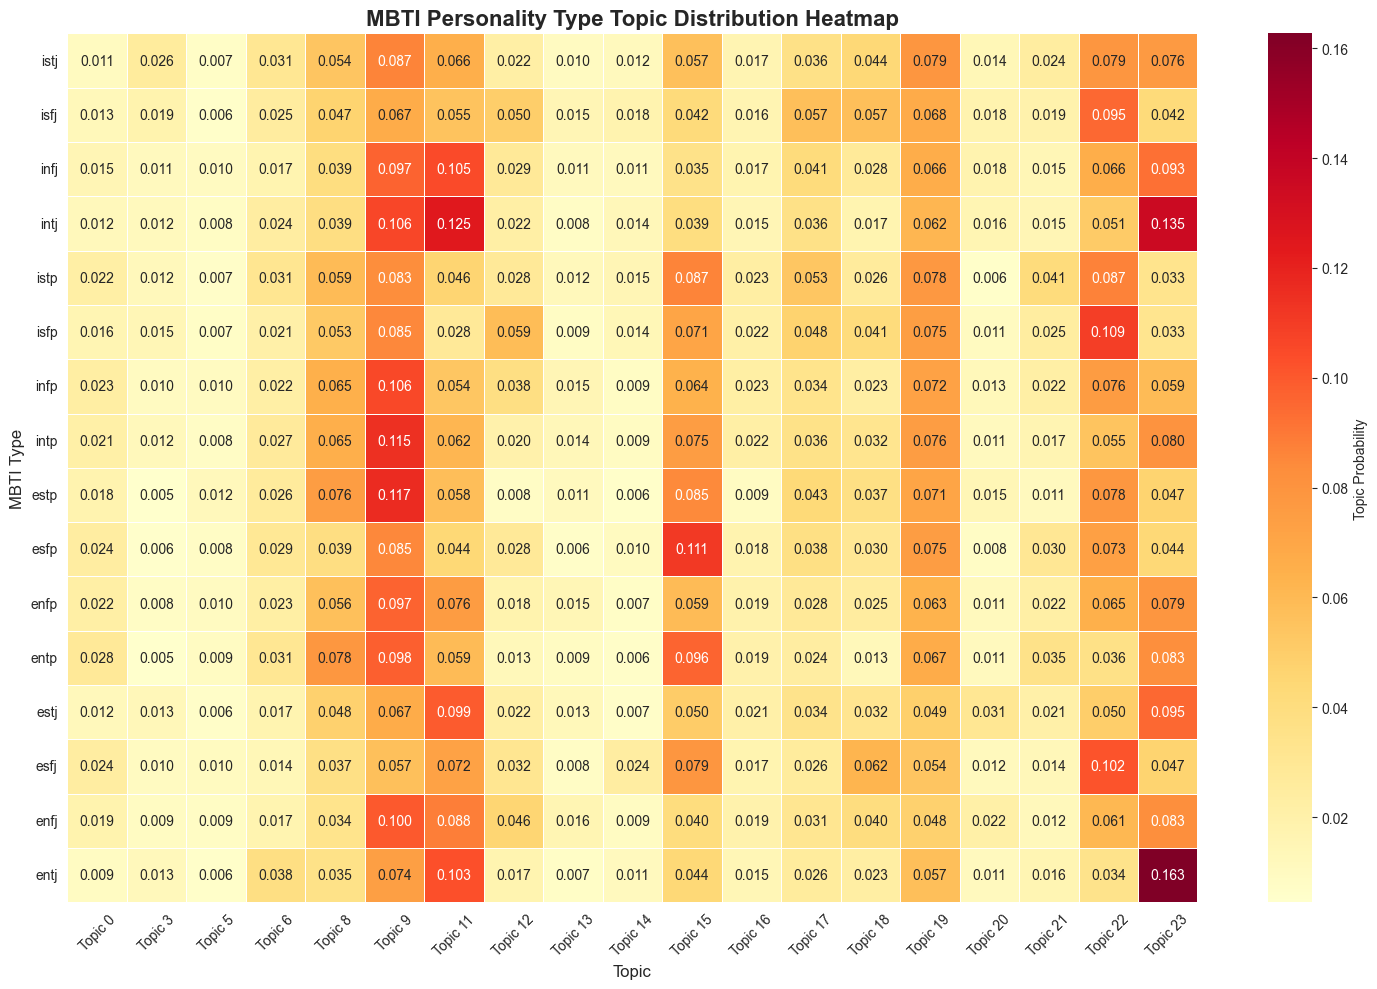

In [185]:
# Create topic distribution heatmap using seaborn
def create_topic_heatmap(topic_dist_df,figsize=(15,10)):
    """Create heatmap of MBTI type topic distributions"""
    plt.figure(figsize=figsize)
    
    # Create heatmap
    sns.heatmap(
        topic_dist_df,
        annot=True,
        fmt='.3f',
        cmap='YlOrRd',
        cbar_kws={'label': 'Topic Probability'},
        linewidths=0.5
    )
    
    plt.title('MBTI Personality Type Topic Distribution Heatmap',fontsize=16,fontweight='bold')
    plt.xlabel('Topic',fontsize=12)
    plt.ylabel('MBTI Type',fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save image
    plt.savefig(f'output/lda_model/lda_{model_id}/visualization/mbti_topic_heatmap.png',dpi=300,bbox_inches='tight')
    plt.show()

create_topic_heatmap(topic_dist_df)


In [186]:
new_index=[
    "enfj","infj","enfp","infp","entj","intj","entp","intp",
    "esfj","isfj","estj","istj","esfp","isfp","estp","istp"
]
topic_rearranged=topic_dist_df.reindex(new_index)
topic_rearranged.head()

,Topic 0,Topic 3,Topic 5,Topic 6,Topic 8,Topic 9,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23
enfj,0.018629,0.009168,0.008683,0.017332,0.033876,0.100159,0.088411,0.045642,0.015653,0.008853,0.040402,0.018903,0.031492,0.039944,0.047873,0.021592,0.012481,0.061163,0.082594
infj,0.015317,0.010826,0.009810,0.017319,0.039322,0.097137,0.104826,0.028553,0.011048,0.011101,0.034973,0.016984,0.041224,0.027707,0.066355,0.018056,0.014692,0.065691,0.092780
enfp,0.022256,0.008053,0.009514,0.022924,0.056489,0.097070,0.075695,0.018451,0.014634,0.007494,0.059213,0.018940,0.028120,0.025341,0.063379,0.011312,0.021965,0.064629,0.079144
infp,0.023067,0.009560,0.009734,0.022100,0.064777,0.105717,0.053740,0.037946,0.015467,0.008565,0.064077,0.022921,0.034068,0.023250,0.072268,0.012555,0.022179,0.075956,0.059148
entj,0.008883,0.012535,0.006063,0.038391,0.035451,0.073925,0.103029,0.017206,0.007427,0.011237,0.043623,0.014521,0.026111,0.023170,0.057445,0.011165,0.016068,0.034339,0.162673


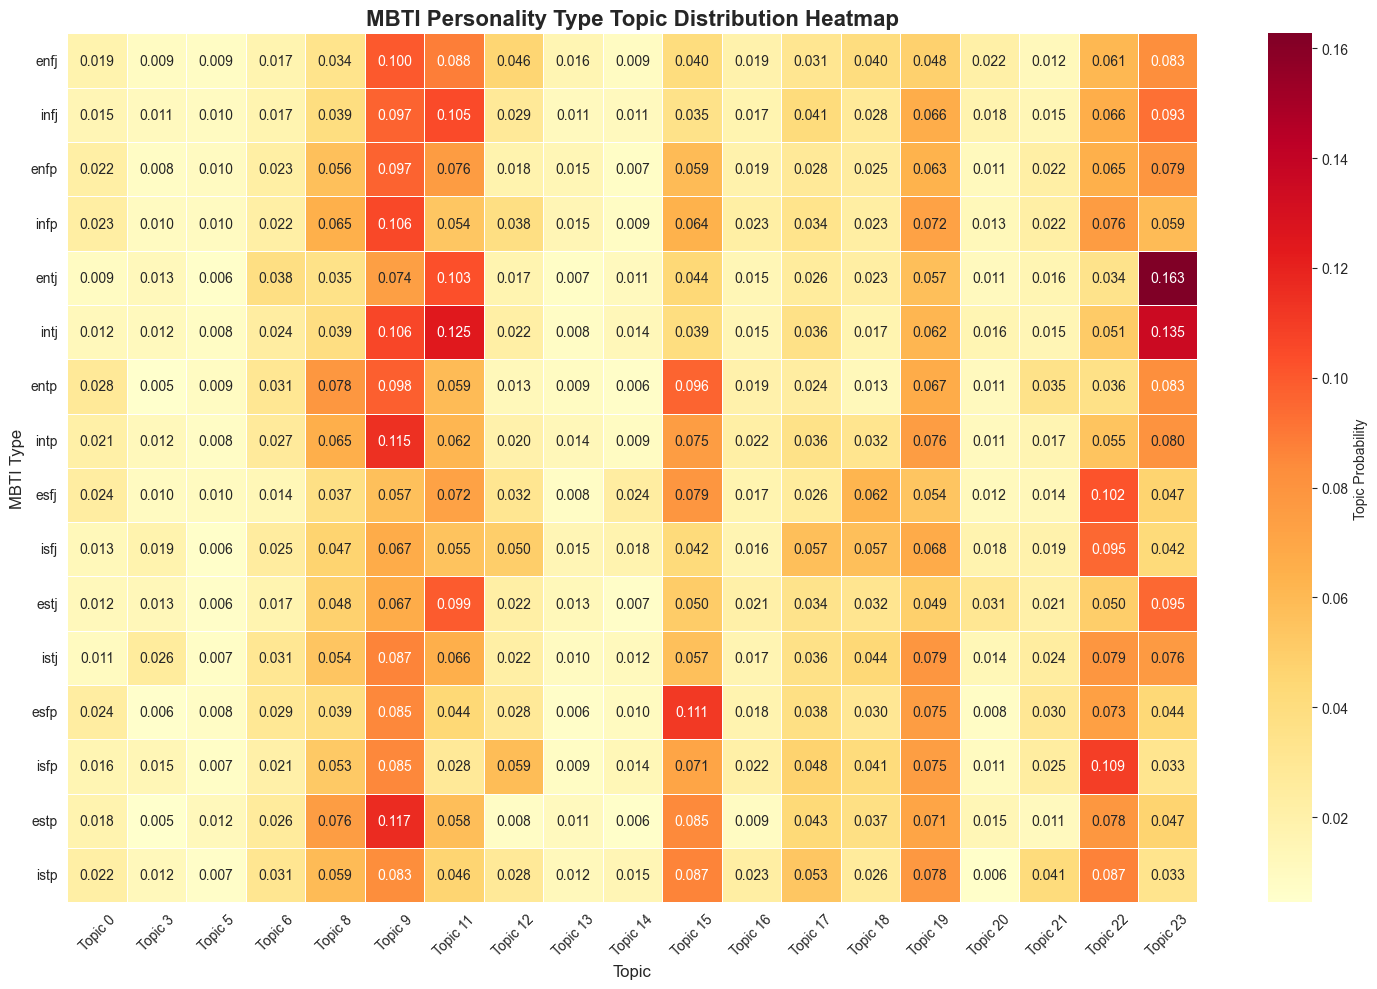

In [187]:
create_topic_heatmap(topic_rearranged)

### Analyze topic preference between MBTI dimensions and groups

MBTI dimension topic preference analysis:


,E,I,S,N,T,F,J,P
Topic 0,0.019410,0.016625,0.017351,0.018684,0.016581,0.019454,0.014277,0.021758
Topic 3,0.008487,0.014503,0.013125,0.009865,0.012169,0.010821,0.014008,0.008981
Topic 5,0.008841,0.007850,0.008016,0.008675,0.008005,0.008686,0.007826,0.008865
Topic 6,0.024605,0.024831,0.024433,0.025003,0.028254,0.021182,0.023051,0.026385
Topic 8,0.050452,0.052652,0.051549,0.051555,0.056836,0.046267,0.041735,0.061369


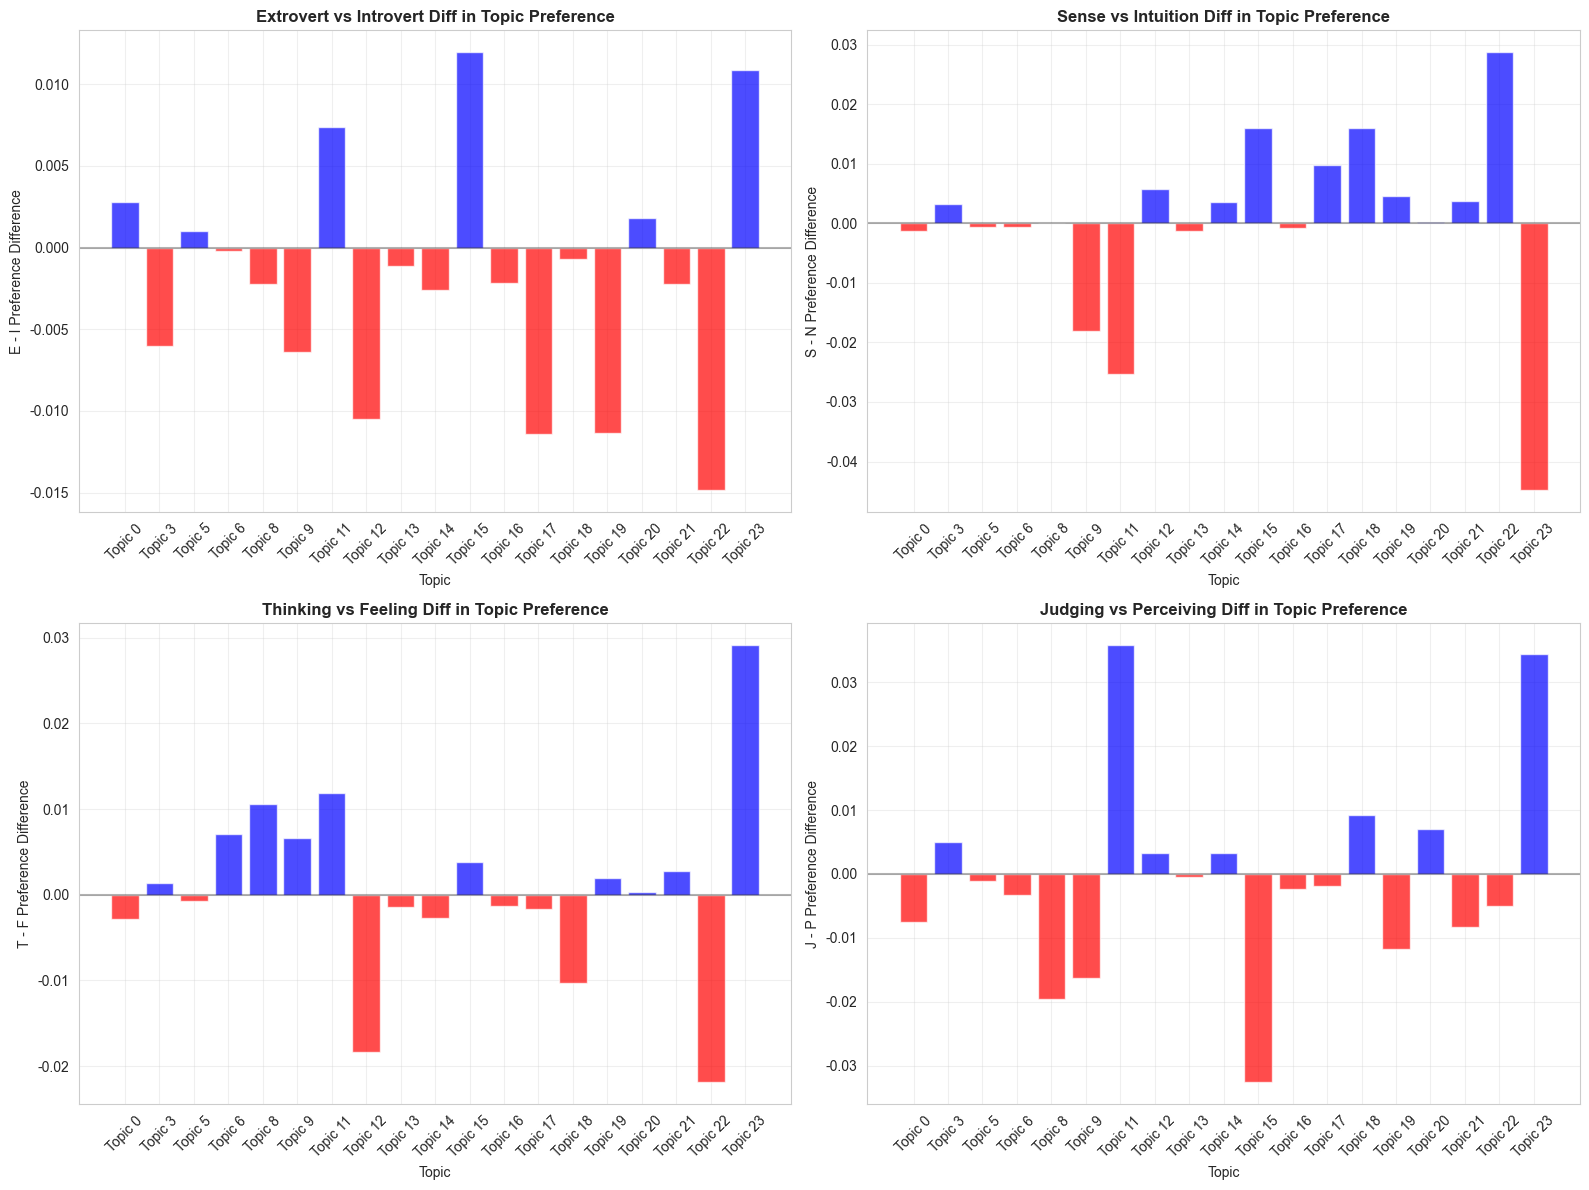

In [188]:
# Create MBTI dimension topic preference analysis
def analyze_mbti_dimensions(topic_dist_df):
    """Analyze topic preferences for MBTI four dimensions"""
    dimension_analysis={}
    
    for dim,types in mbti_dimensions.items():
        # Calculate average topic distribution for this dimension type
        dim_types_in_data=[t for t in types if t in topic_dist_df.index]
        if dim_types_in_data:
            dimension_analysis[dim]=topic_dist_df.loc[dim_types_in_data].mean()
    
    return pd.DataFrame(dimension_analysis)

def create_dimension_comparison(dimension_df):
    """Create MBTI dimension topic preference comparison chart"""
    fig,axes=plt.subplots(2,2,figsize=(16,12))
    axes=axes.flatten()
    
    dimension_pairs=[('E','I'),('S','N'),('T','F'),('J','P')]
    pair_names=['Extrovert vs Introvert','Sense vs Intuition','Thinking vs Feeling','Judging vs Perceiving']
    
    for i,((dim1,dim2),pair_name) in enumerate(zip(dimension_pairs,pair_names)):
        if dim1 in dimension_df.columns and dim2 in dimension_df.columns:
            # Calculate difference
            diff=dimension_df[dim1] - dimension_df[dim2]
            
            # Create bar chart
            x_pos=range(len(diff))
            colors=['red' if x < 0 else 'blue' for x in diff]
            
            axes[i].bar(x_pos,diff,color=colors,alpha=0.7)
            axes[i].axhline(y=0,color='black',linestyle='-',alpha=0.3)
            axes[i].set_title(f'{pair_name} Diff in Topic Preference',fontsize=12,fontweight='bold')
            axes[i].set_xlabel('Topic')
            axes[i].set_ylabel(f'{dim1} - {dim2} Preference Difference')
            axes[i].set_xticks(x_pos)
            axes[i].set_xticklabels([j for j in list(topic_dist_df.columns)],rotation=45)
            axes[i].grid(True,alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'output/lda_model/lda_{model_id}/visualization/mbti_dimension_comparison.png',dpi=300,bbox_inches='tight')
    plt.show()


dimension_df=analyze_mbti_dimensions(topic_dist_df)
print("MBTI dimension topic preference analysis:")
display(dimension_df.head())

create_dimension_comparison(dimension_df)



In [189]:
# Create topic keyword cloud summary
def create_topic_wordcloud_summary(topic_words,topic_dist_df):
    """Create topic keyword summary"""
    print("=" * 60)
    print("Topic keyword summary")
    print("=" * 60)
    
    # Calculate overall popularity of each topic
    topic_popularity=topic_dist_df.mean().sort_values(ascending=False)
    
    for i,(topic_idx,popularity) in enumerate(topic_popularity.items()):
        topic_num=int(topic_idx.replace('Topic',''))
        print(f"\nTopic {topic_num} (Popularity: {popularity:.3f}):")
        print(f"Keywords: {','.join(topic_words[topic_num][:8])}")
        
        # Find the MBTI type that most prefers this topic
        topic_col=f"Topic {topic_num}"
        if topic_col in topic_dist_df.columns:
            top_mbti=topic_dist_df[topic_col].nlargest(3)
            print(f"Most preferred MBTI types: {','.join([f'{mbti}({score:.3f})' for mbti,score in top_mbti.items()])}")
        
        if i >= 9:  # Only show top 10 topics
            break


create_topic_wordcloud_summary(topic_words,topic_dist_df)


Topic keyword summary

Topic 9 (Popularity: 0.090):
Keywords: scene,episode,series,chapter,season,anime,fic,sense
Most preferred MBTI types: estp(0.117),intp(0.115),intj(0.106)

Topic 23 (Popularity: 0.074):
Keywords: state,country,vote,child,trump,american,law,gun
Most preferred MBTI types: entj(0.163),intj(0.135),estj(0.095)

Topic 11 (Popularity: 0.071):
Keywords: experience,self,create,study,student,business,team,test
Most preferred MBTI types: intj(0.125),infj(0.105),entj(0.103)

Topic 22 (Popularity: 0.070):
Keywords: txt,concert,comeback,member,dance,beomgyu,loona,sing
Most preferred MBTI types: isfp(0.109),esfj(0.102),isfj(0.095)

Topic 19 (Popularity: 0.066):
Keywords: express,address,disbelief,informal,kiss,hug,smile,exam
Most preferred MBTI types: istj(0.079),istp(0.078),intp(0.076)

Topic 15 (Popularity: 0.065):
Keywords: lesbian,trans,pride,gender,layout,expression,playful,id
Most preferred MBTI types: esfp(0.111),entp(0.096),istp(0.087)

Topic 8 (Popularity: 0.052):
Keywo

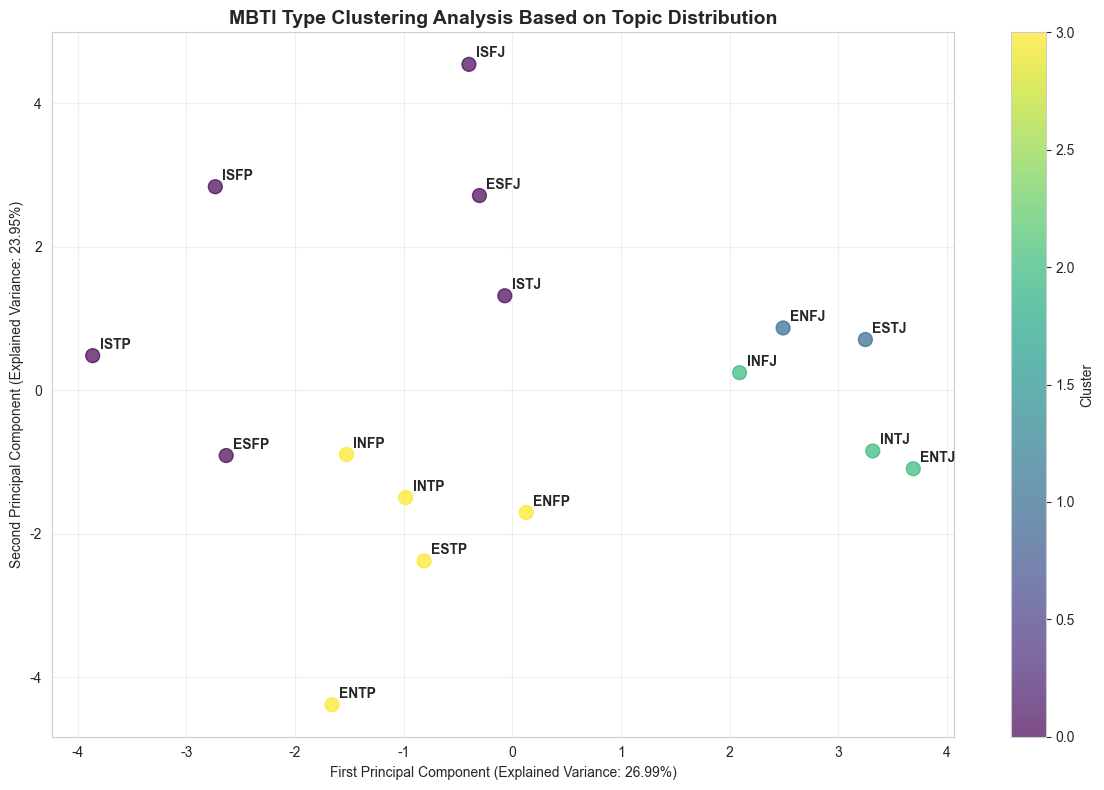


MBTI type clustering results:
Cluster 0: ISTJ,ISFJ,ISTP,ISFP,ESFP,ESFJ
Cluster 1: ESTJ,ENFJ
Cluster 2: INFJ,INTJ,ENTJ
Cluster 3: INFP,INTP,ESTP,ENFP,ENTP


In [190]:
# Create MBTI type clustering analysis
def create_mbti_clustering_analysis(topic_dist_df):
    """Analyze MBTI type clustering based on topic distribution"""
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler
    
    # Standardize data
    scaler=StandardScaler()
    scaled_data=scaler.fit_transform(topic_dist_df)
    
    # PCA dimensionality reduction
    pca=PCA(n_components=2)
    pca_data=pca.fit_transform(scaled_data)
    
    # K-means clustering
    kmeans=KMeans(n_clusters=4,random_state=42)
    clusters=kmeans.fit_predict(scaled_data)
    
    # Create visualization
    plt.figure(figsize=(12,8))
    
    # Plot scatter plot
    scatter=plt.scatter(pca_data[:,0],pca_data[:,1],c=clusters,cmap='viridis',s=100,alpha=0.7)
    
    # Add MBTI type labels
    for i,mbti_type in enumerate(topic_dist_df.index):
        plt.annotate(mbti_type.upper(),(pca_data[i,0],pca_data[i,1]),
                    xytext=(5,5),textcoords='offset points',fontsize=10,fontweight='bold')
    
    plt.title('MBTI Type Clustering Analysis Based on Topic Distribution',fontsize=14,fontweight='bold')
    plt.xlabel(f'First Principal Component (Explained Variance: {pca.explained_variance_ratio_[0]:.2%})')
    plt.ylabel(f'Second Principal Component (Explained Variance: {pca.explained_variance_ratio_[1]:.2%})')
    plt.colorbar(scatter,label='Cluster')
    plt.grid(True,alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'output/lda_model/lda_{model_id}/visualization/mbti_clustering_analysis.png',dpi=300,bbox_inches='tight')
    plt.show()
    
    # Print clustering results
    print("\nMBTI type clustering results:")
    for cluster_id in range(4):
        cluster_types=[topic_dist_df.index[i] for i,c in enumerate(clusters) if c == cluster_id]
        print(f"Cluster {cluster_id}: {','.join([t.upper() for t in cluster_types])}")


create_mbti_clustering_analysis(topic_dist_df)


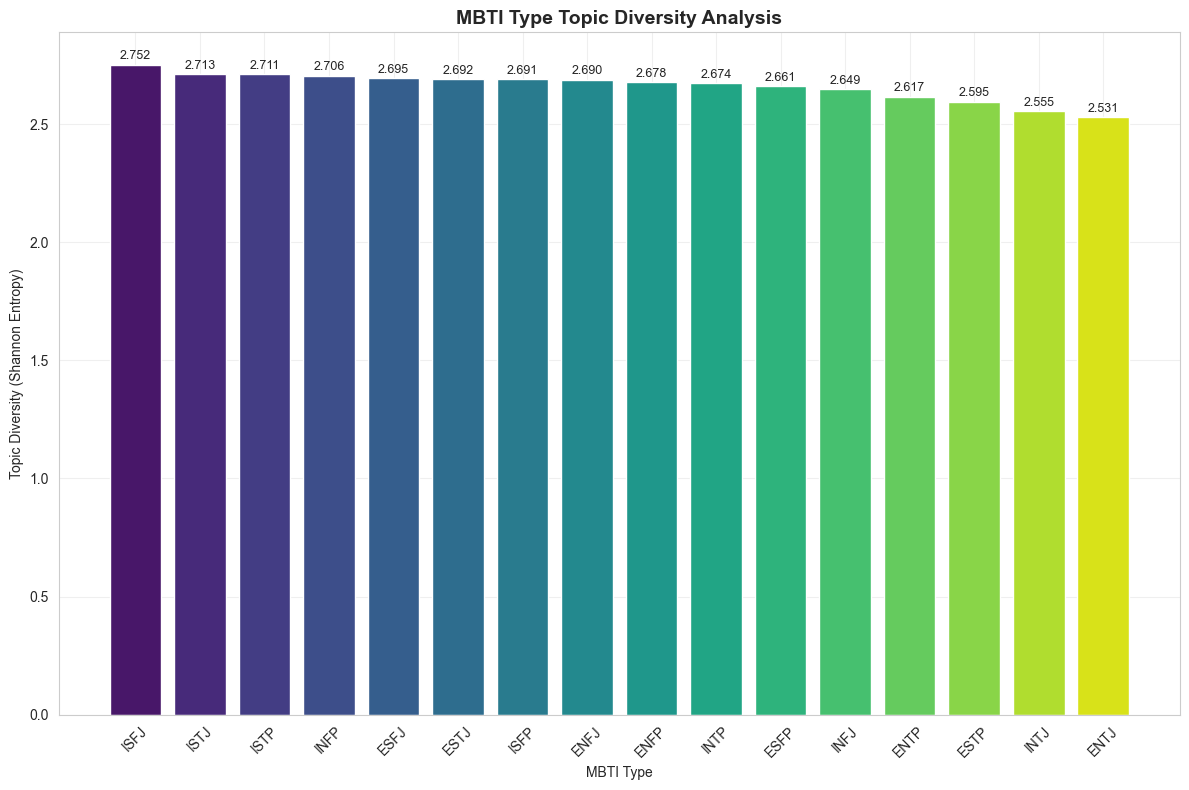


MBTI type topic diversity ranking:


,MBTI Type,Topic Diversity
1,isfj,2.751912
0,istj,2.713350
4,istp,2.710994
6,infp,2.706258
13,esfj,2.694973
12,estj,2.691664
5,isfp,2.690743
14,enfj,2.689600
10,enfp,2.678278
7,intp,2.673683



Analysis explanation:
- The higher the topic diversity,the more widely the MBTI type discusses topics
- The lower the topic diversity,the more focused the MBTI type is on specific topics


In [191]:
# Create topic diversity analysis
def analyze_topic_diversity(topic_dist_df):
    """Analyze topic diversity for each MBTI type"""
    from scipy.stats import entropy
    
    diversity_scores={}
    
    for mbti_type in topic_dist_df.index:
        # Calculate Shannon entropy as diversity metric
        probs=topic_dist_df.loc[mbti_type].values
        # Avoid log(0)
        probs=probs + 1e-10
        diversity_scores[mbti_type]=entropy(probs)
    
    # Create diversity ranking
    diversity_df=pd.DataFrame(list(diversity_scores.items()),
                               columns=['MBTI Type','Topic Diversity'])
    diversity_df=diversity_df.sort_values('Topic Diversity',ascending=False)
    
    # Visualization
    plt.figure(figsize=(12,8))
    bars=plt.bar(range(len(diversity_df)),diversity_df['Topic Diversity'],
                   color=sns.color_palette("viridis",len(diversity_df)))
    
    plt.title('MBTI Type Topic Diversity Analysis',fontsize=14,fontweight='bold')
    plt.xlabel('MBTI Type')
    plt.ylabel('Topic Diversity (Shannon Entropy)')
    plt.xticks(range(len(diversity_df)),
               [t.upper() for t in diversity_df['MBTI Type']],rotation=45)
    
    # Add value labels
    for i,bar in enumerate(bars):
        height=bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.,height + 0.01,
                f'{height:.3f}',ha='center',va='bottom',fontsize=9)
    
    plt.grid(True,alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'output/lda_model/lda_{model_id}/visualization/mbti_topic_diversity.png',dpi=300,bbox_inches='tight')
    plt.show()
    
    return diversity_df


diversity_results=analyze_topic_diversity(topic_dist_df)
print("\nMBTI type topic diversity ranking:")
display(diversity_results)
print("\nAnalysis explanation:")
print("- The higher the topic diversity,the more widely the MBTI type discusses topics")
print("- The lower the topic diversity,the more focused the MBTI type is on specific topics")

In [192]:
# Generate comprehensive analysis report
def generate_analysis_report(topic_dist_df,topic_words):
    """Generate comprehensive analysis report"""
    print("=" * 80)
    print("MBTI personality type topic modeling analysis report")
    print("=" * 80)
    
    # 1. Overall statistics
    print(f"\n1. Overall statistics")
    print(f"   - Number of analyzed MBTI types: {len(topic_dist_df)}")
    print(f"   - Total number of topics: {len(topic_dist_df.columns)}")
    print(f"   - Average topic distribution standard deviation: {topic_dist_df.std(axis=1).mean():.4f}")
    
    # 2. Most distinctive topic preferences
    print(f"\n2. Most distinctive topic preferences")
    for mbti_type in topic_dist_df.index:
        top_topic_idx=topic_dist_df.loc[mbti_type].idxmax()
        top_topic_score=topic_dist_df.loc[mbti_type].max()
        topic_num=int(top_topic_idx.replace('Topic',''))
        top_words=','.join(topic_words[topic_num][:5])
        print(f"   {mbti_type.upper()}: {top_topic_idx} ({top_topic_score:.3f}) - {top_words}")
    
    # 3. Topic popularity ranking
    print(f"\n3. Topic popularity ranking (top 5)")
    topic_popularity=topic_dist_df.mean().sort_values(ascending=False)
    for i,(topic_idx,popularity) in enumerate(topic_popularity.head().items()):
        topic_num=int(topic_idx.replace('Topic',''))
        top_words=','.join(topic_words[topic_num][:5])
        print(f"   {i+1}. {topic_idx} ({popularity:.3f}) - {top_words}")
    
    # 4. MBTI dimension difference summary
    print(f"\n4. MBTI dimension main differences")
    dimension_df=analyze_mbti_dimensions(topic_dist_df)
    
    dimension_pairs=[('E','I'),('S','N'),('T','F'),('J','P')]
    pair_names=['Extroversion vs Introversion','Sensing vs Intuition','Thinking vs Feeling','Judging vs Perceiving']
    
    for (dim1,dim2),pair_name in zip(dimension_pairs,pair_names):
        if dim1 in dimension_df.columns and dim2 in dimension_df.columns:
            diff=dimension_df[dim1] - dimension_df[dim2]
            max_diff_topic=diff.abs().idxmax()
            max_diff_value=diff[max_diff_topic]
            topic_num=int(max_diff_topic.replace('Topic',''))
            
            if max_diff_value > 0:
                preferred_dim=dim1
            else:
                preferred_dim=dim2
                max_diff_value=abs(max_diff_value)
            
            top_words=','.join(topic_words[topic_num][:3])
            print(f"   {pair_name}: {preferred_dim} prefers {max_diff_topic} ({max_diff_value:.3f}) - {top_words}")
    
    print(f"\n" + "=" * 80)
    print("Analysis completed! All visualizations saved to output directory")
    print("=" * 80)


generate_analysis_report(topic_dist_df,topic_words)


MBTI personality type topic modeling analysis report

1. Overall statistics
   - Number of analyzed MBTI types: 16
   - Total number of topics: 19
   - Average topic distribution standard deviation: 0.0303

2. Most distinctive topic preferences
   ISTJ: Topic 9 (0.087) - scene,episode,series,chapter,season
   ISFJ: Topic 22 (0.095) - txt,concert,comeback,member,dance
   INFJ: Topic 11 (0.105) - experience,self,create,study,student
   INTJ: Topic 23 (0.135) - state,country,vote,child,trump
   ISTP: Topic 22 (0.087) - txt,concert,comeback,member,dance
   ISFP: Topic 22 (0.109) - txt,concert,comeback,member,dance
   INFP: Topic 9 (0.106) - scene,episode,series,chapter,season
   INTP: Topic 9 (0.115) - scene,episode,series,chapter,season
   ESTP: Topic 9 (0.117) - scene,episode,series,chapter,season
   ESFP: Topic 15 (0.111) - lesbian,trans,pride,gender,layout
   ENFP: Topic 9 (0.097) - scene,episode,series,chapter,season
   ENTP: Topic 9 (0.098) - scene,episode,series,chapter,season
   ES

In [193]:
# Save analysis results
def save_analysis_results(topic_dist_df,dimension_df=None,diversity_results=None):
    """Save analysis results to file"""
    
    # Save topic distribution matrix
    topic_dist_df.to_csv(f'output/lda_model/lda_{model_id}/visualization/mbti_topic_distributions.csv',encoding='utf-8')
    print(f"Topic distribution matrix saved to: output/lda_model/lda_{model_id}/visualization/mbti_topic_distributions.csv")
    
    # Save dimension analysis results
    if dimension_df is not None:
        dimension_df.to_csv(f'output/lda_model/lda_{model_id}/visualization/mbti_dimension_analysis.csv',encoding='utf-8')
        print(f"Dimension analysis results saved to: output/lda_model/lda_{model_id}/visualization/mbti_dimension_analysis.csv")
    
    # Save diversity analysis results
    if diversity_results is not None:
        diversity_results.to_csv(f'output/lda_model/lda_{model_id}/visualization/mbti_topic_diversity.csv',encoding='utf-8',index=False)
        print(f"Diversity analysis results saved to: output/lda_model/lda_{model_id}/visualization/mbti_topic_diversity.csv")
    
    print("\nAll analysis results saved!")

# Execute saving

dimension_df_to_save=dimension_df
diversity_to_save=diversity_results
save_analysis_results(topic_dist_df,dimension_df_to_save,diversity_to_save)

Topic distribution matrix saved to: output/lda_model/lda_24_5227/visualization/mbti_topic_distributions.csv
Dimension analysis results saved to: output/lda_model/lda_24_5227/visualization/mbti_dimension_analysis.csv
Diversity analysis results saved to: output/lda_model/lda_24_5227/visualization/mbti_topic_diversity.csv

All analysis results saved!
